# Hourly demand
Base demand data is currently restricted to 2012, although it is possible for a user to load 2011 data from IPM that is stored in the PUDL database. The 2012 demand data are aligned with renewables generation data provided with PowerGenome, and with electrification profiles included in the [NREL Electrification Futures Study](https://data.nrel.gov/submissions/126). Although 2012 is a leap year with 8784 hours, PowerGenome removes February 29 by default. If this is a problem, [file an issue](https://github.com/gschivley/PowerGenome/issues) on GitHub and I'll look into making it optional.

**NOTE:** All 2012 load profiles have been compiled using FERC 714 data. Hourly demand from each entity is mapped to the counties that they serve (using EIA 861), and re-apportioned to IPM regions based on population. Anomalies were detected and fixed using code developed by [Tyler Ruggles and David Farnham](https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Code). Loads in each region are then adjusted based on the ratio of FERC load in 2011 to IPM load in 2011. **Finally, all load has been shifted to UTC time, which matches generation profiles linked to in the README.** The regions `WECC_SNV`, `MIS_MO`, and `PJM_SMAC` have total/peak load that is more than 30% off from IPM 2011 data. Future versions of the data may use different allocation methods that also account for large industrial/commercial loads. I'll post any updated on the [PowerGenome groups.io](https://groups.io/g/powergenome) site.

Hourly demand is one of the few remaining areas of PowerGenome where users may need to supply data, although this is limited to hourly profiles of demand response resources (possibly from the NREL data) and hourly profiles/capacity of distributed generation. Rooftop solar PV profiles can be obtained from sources such as NREL or [Renewables.ninja](https://www.renewables.ninja/).

Examples of user-supplied data - including load profiles - are included in `example_system/extra_inputs`. The corresponding parameters are
- `distributed_gen_profiles_fn`
- `demand_response_fn`
- `regional_load_fn` 

Note that if external load profiles include electrification/demand reponse load you should set the parameter `regional_load_includes_demand_response` to `True`. In this case the demand response profiles are used to calculate capacity of the resource in each planning year (in the new generators data), but they are not added to the load profiles.

Distributed generation profiles, which are normalized from 0-1, can be scaled as either a fraction of total load (in cases where DG is part of an RPS set-aside) or according to a total capacity (where capacity projections are available). This is done using the parameters
- `distributed_gen_method` (key: region name, value: `capacity` or `fraction_load`)
- `distributed_gen_values` (nested dictionary for each planning year)
- `avg_distribution_loss` (simplified as a single value for all regions, used to scale up DG when subtracting from total load)

Final load profiles are calculated as follows:
1. Read hourly load data from either the PUDL sqlite database or the user-supplied CSV file.
2. If read from sqlite:  
    a. Combine IPM regions into model regions using the `region_aggregations` parameter.  
    b. Scale up hourly load from base year (2012) to 2018 using historical demand from EIA AEO electricity market module (EMM) regions (AEO 2014 and AEO 2019, IPM regions mapped to EMM regions in the parameter `historical_load_region_maps`). Scale from 2019 to the model year using AEO 2020. EIA changed AEO EMM regions in 2020, and IPM regions are mapped to the new EMM regions in the parameter `future_load_region_map`.   
3. If loaded from sqlite, or user-supplied data and values do not include demand response, add DR profiles to load profiles (if hourly DR demand is supplied by the user).
4. If distributed generation curves and scaling method/values are provided, subtract DG from load curves.




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
from powergenome.load_profiles import (
    make_load_curves, 
    add_load_growth, 
    make_final_load_curves, 
    make_distributed_gen_profiles,
)
from powergenome.external_data import make_demand_response_profiles
from powergenome.generators import GeneratorClusters
from powergenome.util import (
    build_scenario_settings,
    init_pudl_connection,
    load_settings,
    reverse_dict_of_lists,
    remove_feb_29
)

## Import settings
This assumes that the settings file is set up for multiple scenarios/planning periods. If you are using a settings file with only a single scenario/planning period, remove or comment out the line with `build_scenario_settings`.

In [3]:
pudl_engine, pudl_out = init_pudl_connection()
cwd = Path.cwd()

settings_path = (
    cwd.parent / "example_system" / "test_settings.yml"
)
settings = load_settings(settings_path)
settings["input_folder"] = settings_path.parent / settings["input_folder"]
scenario_definitions = pd.read_csv(
    settings["input_folder"] / settings["scenario_definitions_fn"]
)
scenario_settings = build_scenario_settings(settings, scenario_definitions)

## Build load curves
If you just want the final load curves that include any demand response/distributed generation, the function `make_final_load_curves` is all you need.

In [120]:
load_curves = make_final_load_curves(pudl_engine, scenario_settings[2030]["p1"])
load_curves

region,CA_N,CA_S,WECC_AZ
time_index,,,
1,13760,17867,10586
2,15692,20265,11283
3,15881,20513,10980
4,15391,19889,10608
5,14856,19219,10275
...,...,...,...
8756,15383,17122,10629
8757,15056,16770,10393
8758,14762,16461,10238


<AxesSubplot:xlabel='time_index'>

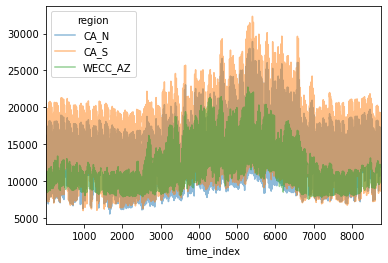

In [122]:
load_curves.plot(alpha=0.5)

In [106]:
dr_path = settings["input_folder"] / settings["demand_response_fn"]
dr_types = settings["demand_response_resources"][scenario_settings[2030]["p1"]["model_year"]].keys()
dr_profiles = make_demand_response_profiles(dr_path, list(dr_types)[0], scenario_settings[2030]["p1"])
dr_profiles

,CA_N,CA_S
0,52.8,68.1
1,49.3,63.6
2,19.0,24.5
3,14.4,18.6
4,9.1,11.8
...,...,...
8755,367.7,474.1
8756,357.6,461.0
8757,302.8,390.3
8758,52.8,68.1


In [102]:
dg_profiles = make_distributed_gen_profiles(pudl_engine, scenario_settings[2030]["p1"])
dg_profiles

,CA_N,CA_S
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
8755,0.0,0.0
8756,0.0,0.0
8757,0.0,0.0
8758,0.0,0.0


In [98]:
ferc_load = make_load_curves(pudl_engine, scenario_settings[2030]["p1"])

In [99]:
ferc_load.head()

region,CA_N,CA_S,WECC_AZ
time_index,,,
1,13707.788389,17798.980686,10586.877504
2,15643.587191,20202.398075,11283.287294
3,15862.345730,20488.780490,10980.670394
4,15376.958891,19871.281472,10608.722949
5,14847.046903,19208.107593,10275.752378


In [100]:
remove_feb_29(ferc_load)

region,CA_N,CA_S,WECC_AZ
time_index,,,
1,13707.788389,17798.980686,10586.877504
2,15643.587191,20202.398075,11283.287294
3,15862.345730,20488.780490,10980.670394
4,15376.958891,19871.281472,10608.722949
5,14847.046903,19208.107593,10275.752378
...,...,...,...
8756,15016.263374,16648.329586,10629.418634
8757,14698.525220,16310.001163,10393.602805
8758,14460.012566,16071.070432,10238.040241


In [12]:
ipm_load = make_load_curves(pudl_engine, scenario_settings[2030]["p1"], pudl_table="load_curves_epaipm")

In [73]:
ipm_load

region,CA_N,CA_S,WECC_AZ
time_index,,,
1,13123.737825,16287.079148,10587.478303
2,12764.344649,16666.035060,12255.250283
3,12275.974501,15964.104655,12136.544922
4,11916.747275,15465.462932,12132.373934
5,11742.875187,15192.182493,12194.507273
...,...,...,...
8756,15886.815401,20163.654372,11037.034110
8757,15423.386069,19557.446030,10683.554856
8758,14940.948310,18853.834625,10368.189804


In [17]:
ferc_load.sum()

region
CA_N       1.417493e+08
CA_S       1.624487e+08
WECC_AZ    1.037908e+08
dtype: float64

In [18]:
ipm_load.sum()

region
CA_N       1.301454e+08
CA_S       1.677806e+08
WECC_AZ    1.041252e+08
dtype: float64

In [108]:
make_final_load_curves(pudl_engine, scenario_settings[2030]["p1"]).sum()

region
CA_N       131027784
CA_S       147272818
WECC_AZ    103539431
dtype: int64

In [119]:
make_final_load_curves(pudl_engine, scenario_settings[2030]["p1"], pudl_table="load_curves_epaipm").sum()

[autoreload of powergenome.externals.cpi.cpi failed: Traceback (most recent call last):
  File "/Users/Home/opt/miniconda3/envs/powergenome/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/Home/opt/miniconda3/envs/powergenome/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/Home/opt/miniconda3/envs/powergenome/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/Home/opt/miniconda3/envs/powergenome/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/Home/Documents/CATF/PowerGenome/powergenome/externals/cpi/cpi/

region
CA_N       119797084
CA_S       153030377
WECC_AZ    104120904
dtype: int64

In [109]:
make_final_load_curves(pudl_engine, scenario_settings[2030]["p1"]).describe()

region,CA_N,CA_S,WECC_AZ
count,8760.000000,8760.000000,8760.000000
mean,14957.509589,16811.965525,11819.569749
std,4227.929784,5177.460634,2974.485509
min,5565.000000,6029.000000,7561.000000
25%,11600.000000,12504.500000,9787.000000
50%,15584.000000,17783.500000,10812.000000
75%,17406.000000,19934.250000,13147.500000
max,28912.000000,32324.000000,22740.000000


In [111]:
ca_s_regions = settings["region_aggregations"]["CA_S"]
ca_s_regions

['WEC_SCE', 'WEC_LADW', 'WECC_SCE', 'WEC_SDGE', 'WECC_IID']

In [114]:
ipm_table = pd.read_sql_table("load_curves_epaipm", pudl_engine)

In [116]:
ipm_table.query("region_id_epaipm.isin(@ca_s_regions).values")["load_mw"].sum()

160526211.35428733

In [117]:
ferc_table = pd.read_sql_table("load_curves_ferc", pudl_engine)

In [118]:
ferc_table.query("region_id_epaipm.isin(@ca_s_regions).values")["load_mw"].sum()

155424890.8